In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

**Pro tip:** windowed_dataset() returns 2 dimensional data, with the first dimension being the batch size, and the second dimension being the number of time steps. However, an RNN expects 3 dimensions: batch size, no. of time steps and series dimensionality (univariate, bivariate, etc.). Lambda layers let you add custom functions to your architecture, and we can use it to add dimensionality here without needing to modify windowed_dataset(). We set the new dimension to None, which means the RNN can accept sequences of any length.

**Pro tip:** The output of the RNN is given by the default tanh activation function whose values lie between -1 and 1. However time series values usually lie in the order of 50s, 60s, 70s etc. So scaling up the RNN output to the same ballpark can help with learning.

**Pro tip:** The Huber loss function is less sensitive to noise. The data used here can get noisy, so it's worth giving it a shot!

**Note:** Recall how the learning rate scheduler works. It updates the learning rate at every epoch and then calculates the loss using that learning rate. In the end, you have the loss values for a number of different learning rates applied to the *same data*. This lets you choose the optimal rate.

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 27ms/step - loss: 195.5726 - mae: 196.0726 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 194.7820 - mae: 195.2820 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 193.5110 - mae: 194.0110 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 191.9081 - mae: 192.4081 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 190.0235 - mae: 190.5235 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 187.8583 - mae: 188.3583 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 185.3787 - mae: 185.8787 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 182.5484 - mae: 183.0484 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 20ms/step - loss: 179.3126 - mae: 

(1e-08, 0.0001, 0.0, 30.0)

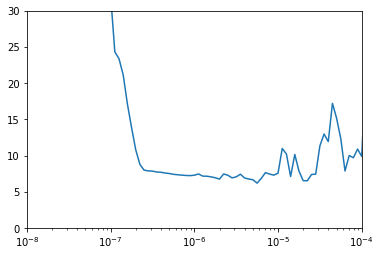

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 22ms/step - loss: 117.2726 - mae: 117.7723
Epoch 2/400
8/8 [==============================] - 0s 22ms/step - loss: 44.0110 - mae: 44.5084
Epoch 3/400
8/8 [==============================] - 0s 22ms/step - loss: 22.3318 - mae: 22.8266
Epoch 4/400
8/8 [==============================] - 0s 22ms/step - loss: 12.9401 - mae: 13.4327
Epoch 5/400
8/8 [==============================] - 0s 25ms/step - loss: 10.2014 - mae: 10.6848
Epoch 6/400
8/8 [==============================] - 0s 23ms/step - loss: 8.3283 - mae: 8.8151
Epoch 7/400
8/8 [==============================] - 0s 22ms/step - loss: 6.9705 - mae: 7.4522
Epoch 8/400
8/8 [==============================] - 0s 23ms/step - loss: 6.4044 - mae: 6.8822
Epoch 9/400
8/8 [==============================] - 0s 22ms/step - loss: 6.0183 - mae: 6.4993
Epoch 10/400
8/8 [==============================] - 0s 23ms/step - loss: 5.8204 - mae: 6.2997
Epoch 11/400
8/8 [==============================] - 0s 23

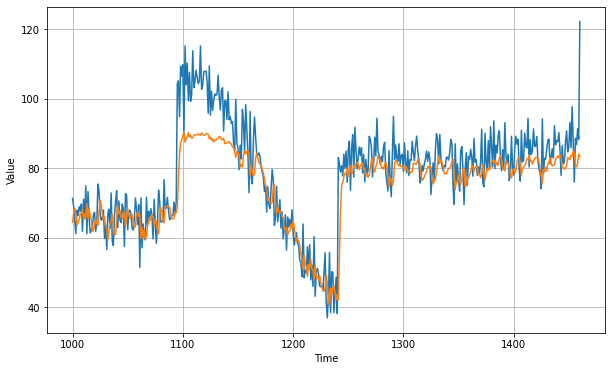

In [0]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.080603

**Note:** The model was originally trained for 500 epochs. However, the MAE and loss curves showed a lot of noise between epoch 400 and 500, so the number of epochs to train was reduced to 400. There wasn't a significant decrease in accuracy, but since we achieved it with a 100 less epochs to train, it was worth it!

<Figure size 432x288 with 0 Axes>

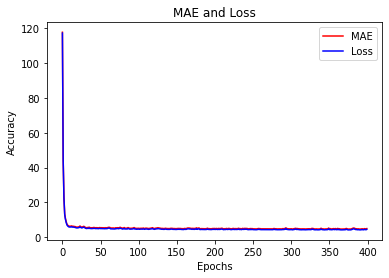

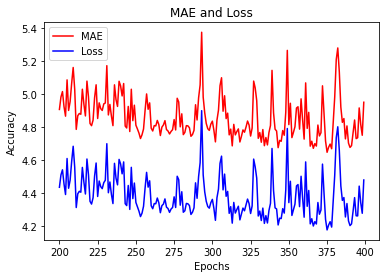

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()